In [1]:
import random
import queueing_tool as qt
import pandas as pd

Define service function

In [2]:
def ser(t: float):
    """Define deterministic service time.\n
    Take the arrival time as t and add a constant.

    Args:
        t (float): current time
    """
    return t + 0.00112

Define the two agents:
- slow agents that go through the whole system
- fast agents that overload the system and leave

In [3]:
def ag_slow(label):
    return qt.Agent(
        arrival_f = lambda t: t + random.expovariate(lambd=125),
        agent_id= (0, 0, 'slow')
)

def ag_fast(label):
    return qt.Agent(
        arrival_f = lambda t: t + random.expovariate(lambd=500),
        agent_id= (0, 0, 'fast')
)

System definition

```mermaid
---
title: One-node M/D/1 system
---
  graph LR;
  A("Entry point")
  B("Leaving point")
  λ0("slow λ")
  λ1("fast λ")

      λ0 --> A
      λ1 --> node
      A --> node --> B
```

In [19]:
# Prepare the one-node network
q_classes = { 1: qt.QueueServer, 2: qt.QueueServer, 3: qt.QueueServer }

adja_list = {
    0: [1],
    1: [3],
    2: [3]
}
edge_list = {
    0: {1: 1},
    1: {3: 3},
    2: {3: 3}
}
g = qt.adjacency2graph(
    adjacency=adja_list,
    edge_type=edge_list
)

q_args = {
    1: {
        'service_f': lambda t: t,
        'AgentFactory': ag_slow,
    },
    2: {
        'service_f': lambda t: t,
        'AgentFactory': ag_fast,
    },
    3: {
        'num_servers': 1,
        'service_f': ser,
    },
}

qn = qt.QueueNetwork(
    g= g, q_classes=q_classes, q_args=q_args
)

Simulate

In [20]:
qn.initialize()
qn.start_collecting_data()
qn.simulate(n=200)
dat = qn.get_agent_data(return_header=True)

for k, v in dat[0].items():
    print(k)
    print(v)

(0, 0, 'slow')
[[ 0.66643346  0.66643346  0.66643346  0.          1.          0.        ]
 [ 0.66643346  0.66643346  0.66755346  0.          1.          1.        ]
 [ 0.66755346  0.          0.          0.          0.          3.        ]
 ...
 [62.21592812  0.          0.          0.          0.          3.        ]
 [64.99198248 64.99198248  0.          0.          1.          1.        ]
 [64.99198248 64.99198248 64.99198248  0.          1.          0.        ]]


c:\Users\marco_\Documents\Queueing_project\queueing\venv\Lib\site-packages\queueing_tool\network\queue_network.py:566: UserWarning: frames=None which we can infer the length of, did not pass an explicit *save_count* and passed cache_frame_data=True.  To avoid a possibly unbounded cache, frame data caching has been disabled. To suppress this warning either pass `cache_frame_data=False` or `save_count=MAX_FRAMES`.
  animation = FuncAnimation(**animation_args)


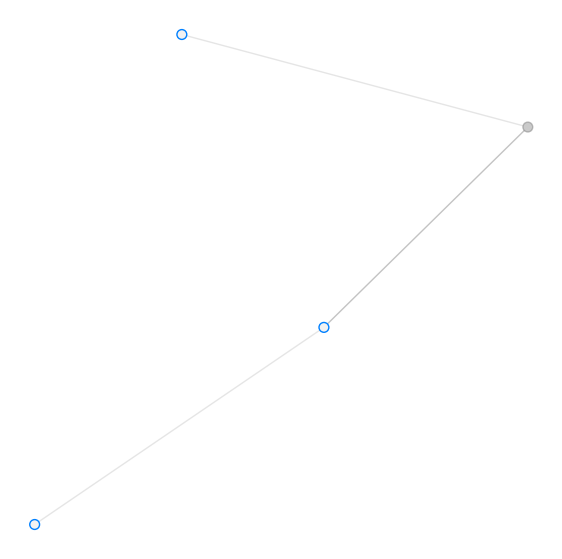

c:\Users\marco_\Documents\Queueing_project\queueing\venv\Lib\site-packages\matplotlib\animation.py:892: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


In [21]:
qn.animate()